# Planet: Understanding the Amazon from Space
## By Adedamola Babayato
## ID: 157372abee81f000

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing other libraries
import matplotlib.pyplot as plt
from keras import applications
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten
from keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.metrics import fbeta_score


In [3]:
# loading the csv & image files
train_df = pd.read_csv('../input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv')
train_dir ='../input/planets-dataset/planet/planet/train-jpg'
test_dir = '../input/planets-dataset/planet/planet/test-jpg'

In [4]:
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


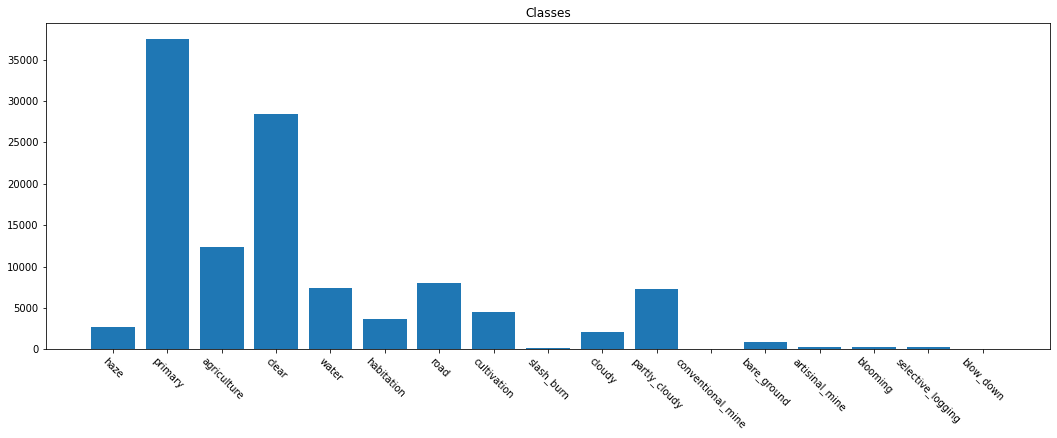

In [5]:
# numbers of tags and their names
counts = {}
splitting_tags = train_df['tags'].map(lambda x: x.split(' '))
for labels in splitting_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

In [6]:
#define a function to split the tags and store a set of the tags in a variable called labels.
#set is used to return the unique labels in the tags
labels = set()
def splitting_tags(tags):
    for tag in tags.split():
        labels.add(tag)

train_df['tags'].apply(splitting_tags)
labels = list(labels)
# print(labels)

In [7]:
#one hot encoding is performed on the labels in train classes
for tag in labels:
    train_df[tag] = train_df['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
#adding .jpg extension to the column image_name so as to have same name format as the image files
train_df['image_name'] = train_df['image_name'].apply(lambda x: '{}.jpg'.format(x))


In [8]:
#defining the columns, that is the labels that were newly added to the train_classes via hot encoding.
columns = list(train_df.columns[2:]) #from index 2 to the end defines the columns
columns

['habitation',
 'cultivation',
 'slash_burn',
 'partly_cloudy',
 'artisinal_mine',
 'haze',
 'water',
 'cloudy',
 'primary',
 'road',
 'blooming',
 'clear',
 'selective_logging',
 'blow_down',
 'agriculture',
 'conventional_mine',
 'bare_ground']

**F beta score - metric**

In [9]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
 
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
 
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

**Now its time to create the image data authmentation object for the training and testing dataset**

In [10]:
#initializing imagedatagenerator with a validation split of 0.2
train_image_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

#generating train data generator which is 80% of the train dataset
train_generator = train_image_gen.flow_from_dataframe(train_df,
                                                directory ="../input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="training", 
                                                batch_size=16, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_image_gen.flow_from_dataframe(train_df,
                                                directory ="../input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="validation", 
                                                batch_size=16, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [11]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

**CNN Model Architecture** 

In [12]:
def build_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    opt = Adam(learning_rate=1e-4)

    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[fbeta])

    return model

In [13]:
#initializing the model
model = build_model()

# Print the model architecture to take a look at the number of parameters that the model will learn.

model.summary()

2022-09-20 22:23:46.196088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        3

2022-09-20 22:23:46.296151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:23:46.296870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:23:46.298228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 22:23:46.298536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [14]:
history = model.fit(x = train_generator, steps_per_epoch = step_train_size, validation_data = val_generator, 
           validation_steps = step_val_size,epochs = 25)

Epoch 1/25


2022-09-20 22:23:49.175832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-20 22:23:51.130158: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2024/2024 [==============================] - 259s 124ms/step - loss: 0.2174 - fbeta: 0.6746 - val_loss: 0.1643 - val_fbeta: 0.7445
Epoch 2/25
2024/2024 [==============================] - 109s 54ms/step - loss: 0.1617 - fbeta: 0.7636 - val_loss: 0.1414 - val_fbeta: 0.7694
Epoch 3/25
2024/2024 [==============================] - 110s 54ms/step - loss: 0.1454 - fbeta: 0.7889 - val_loss: 0.1409 - val_fbeta: 0.7945
Epoch 4/25
2024/2024 [==============================] - 108s 54ms/step - loss: 0.1366 - fbeta: 0.8014 - val_loss: 0.1249 - val_fbeta: 0.8088
Epoch 5/25
2024/2024 [==============================] - 106s 53ms/step - loss: 0.1298 - fbeta: 0.8145 - val_loss: 0.1218 - val_fbeta: 0.8269
Epoch 6/25
2024/2024 [==============================] - 106s 53ms/step - loss: 0.1238 - fbeta: 0.8260 - val_loss: 0.1182 - val_fbeta: 0.8282
Epoch 7/25
2024/2024 [==============================] - 107s 53ms/step - loss: 0.1194 - fbeta: 0.8322 - val_loss: 0.1116 - val_fbeta: 0.8325
Epoch 8/25
2024/2024 [=

In [15]:
model.save('best_model.h5')

**Prediction & Evaluation**

In [16]:
# Read in sample submission file
sample_submission = pd.read_csv('../input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv')

#Adding .jpg extension to image name in the sample submission file
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))

sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [17]:
#loading in the weights of the trained model so we can make predictions with it
model.load_weights('best_model.h5')

In [18]:
#we divide the sample submission file into two splits, first test1_df which contains the first 40669 images 
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [19]:
#initializing imagedatagenerator for the test images and also rescaling
test_image_gen = ImageDataGenerator(rescale = 1/255)


#creating a generator for the images found in the first test image files
test_generator1 = test_image_gen.flow_from_dataframe(test1_df, 
                                                directory="../input/planets-dataset/planet/planet/test-jpg", 
                                                x_col="image_name", y_col=None, batch_size=16, 
                                                shuffle=False, class_mode=None, target_size=(128,128))

step_test_size1 = int(np.ceil(test_generator1.samples/test_generator1.batch_size))

Found 40669 validated image filenames.


In [20]:
#first, we reset the test generator to avoid shuffling of index as we want it to be orderly
test_generator1.reset()
pred1 = model.predict(test_generator1, steps = step_test_size1, verbose = 1)


2542/2542 [==============================] - 263s 103ms/step


In [21]:
#this is to get the filenames in the generator using the attribute .filenames
file_names1 = test_generator1.filenames

#convert the predicted values to a dataframe and join two labels together if the probability of occurrance of the label is greater than 0.5 
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(labels)[x>0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,cultivation primary clear agriculture
4,test_4.jpg,cloudy


In [22]:
#second batch of the test dataset
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)

#creating a generator for the second batch of test image files
test_generator2 = test_image_gen.flow_from_dataframe(test2_df, 
                                                directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                x_col="image_name", y_col=None, batch_size=16, 
                                                shuffle=False, class_mode=None, target_size=(128,128))

step_test_size2 = int(np.ceil(test_generator2.samples/test_generator2.batch_size))

Found 20522 validated image filenames.


In [24]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_generator2.reset()
pred2 = model.predict(test_generator2, steps = step_test_size2, verbose = 1)

1283/1283 [==============================] - 107s 84ms/step


In [25]:
#this is to get the filenames in the generator using the attribute .filenames
file_names2 = test_generator2.filenames

#convert the predicted values to a dataframe and join two labels together if the probability of occurrance of the label is greater than 0.5
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

#then the result should look like this
result2 = pd.DataFrame({'image_name': file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,primaryclear
1,file_1.jpg,partly_cloudyprimaryagriculture
2,file_10.jpg,hazeprimaryroadagriculture
3,file_100.jpg,waterprimaryclear
4,file_1000.jpg,primaryclear


In [26]:
#for the final result of the predicted tags for the test images, we need to concat the first and second results in that order to avoid shuffling the index
final_result = result1.append(result2, ignore_index=True)

#print the final result shape
print(final_result.shape)

final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,cultivation primary clear agriculture
4,test_4.jpg,cloudy


In [27]:
#Remove the .jpg extension from the image_name of the final_result 
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,partly_cloudy primary
3,test_3,cultivation primary clear agriculture
4,test_4,cloudy


**Storing Final Dataset**

In [28]:
#Finally, store the result to a csv file using the .to_csv() method and setting the index to false.
final_result.to_csv('final_submission.csv', index = False)